In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [2]:
df = pd.read_csv('./merged.csv', index_col=0)

In [3]:
df.head()

,Stkcd,Trdmnt,Mretwd,rf,rm
0,600000,2013-01-01,0.157258,0.2466,0.064975
1,600000,2013-02-01,-0.036585,0.2466,-0.005045
2,600000,2013-03-01,-0.084087,0.2466,-0.066675
3,600000,2013-04-01,-0.024679,0.2466,-0.019148
4,600000,2013-05-01,0.059717,0.2466,0.065018


In [4]:
df[df['Mretwd'].isna()].describe()

,Stkcd,Mretwd,rf,rm
count,518.000000,0.0,518.000000,518.000000
mean,603144.882239,NaN,0.146876,0.018894
std,890.422337,NaN,0.042070,0.059920
min,600023.000000,NaN,0.124100,-0.146725
25%,603079.250000,NaN,0.124100,-0.004714
50%,603373.000000,NaN,0.124100,0.019141
75%,603712.750000,NaN,0.124100,0.038660
max,603999.000000,NaN,0.246600,0.258075


In [5]:
stock_codes = pd.unique(df['Stkcd'])

stock_dfs = []
stock_betas = []

for stock in stock_codes:
    stock_dfs.append(df[df['Stkcd']==stock])

In [6]:
Regression_df = pd.DataFrame({'Stock': [], "Alpha": [], "Beta": [], "ri-rf": []})

In [7]:
Regression_df['Stock'] = stock_codes

In [8]:
Regression_df.head()

,Stock,Alpha,Beta,ri-rf
0,600000,NaN,NaN,NaN
1,600004,NaN,NaN,NaN
2,600005,NaN,NaN,NaN
3,600006,NaN,NaN,NaN
4,600007,NaN,NaN,NaN


## First Pass Regression

Periodic cross-sectional regression, regress each stock across T periods:

$$ r_{it}-r_{ft} = \alpha_i+\beta_i(r_{mt}-r_{ft})+\epsilon_{it} $$

to calculate each stock's beta

In [44]:
stock_df = stock_dfs[900]
stock_df = stock_df.dropna(axis=0, how='any')
LR = LinearRegression()
ri = stock_df['Mretwd']
rf = stock_df['rf']
rm = stock_df['rm']
X = (rm-rf).values
X = X.reshape((X.shape[0],1))
y = (ri-rf).values
y = y.reshape((y.shape[0],1))
LR.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

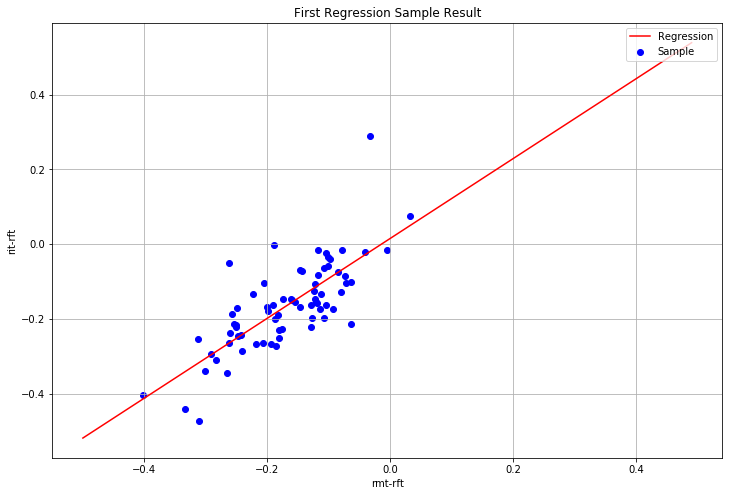

In [45]:
fig = plt.figure(figsize=(12,8))

plt.title("First Regression Sample Result")
plt.scatter(X,y, color='b', label='Sample')
plt.plot(np.arange(-0.5,0.5,0.01), LR.predict(np.arange(-0.5,0.5,0.01).reshape((-1,1))), color='r', label='Regression')
plt.grid(True)
plt.xlabel("rmt-rft")
plt.ylabel("rit-rft")
plt.legend(loc=1)

In [46]:
for idx in range(Regression_df.shape[0]):
    try:
        stock_df = stock_dfs[idx]
        stock_df = stock_df.dropna(axis=0, how='any')
        LR = LinearRegression()
        ri = stock_df['Mretwd']
        rf = stock_df['rf']
        rm = stock_df['rm']
        X = (rm-rf).values
        X = X.reshape((X.shape[0],1))
        y = (ri-rf).values
        y = y.reshape((y.shape[0],1))
        LR.fit(X,y)
        row = Regression_df.iloc[idx]
        row['Alpha'] = LR.intercept_
        row['Beta'] = LR.coef_
        row['ri-rf'] = np.mean(y)
        Regression_df.iloc[idx] = row
    except ValueError:
        print("ValueError with stock idx=%d\n"%idx)

ValueError with stock idx=1108

ValueError with stock idx=1277



In [47]:
Regression_df.head()

,Stock,Alpha,Beta,ri-rf
0,600000.0,-0.033417,0.767625,-0.162832
1,600004.0,-0.005789,0.900694,-0.157637
2,600005.0,0.009200,1.023623,-0.187596
3,600006.0,-0.059743,0.596995,-0.161760
4,600007.0,-0.028217,0.821840,-0.166771


In [48]:
Regression_df.loc[Regression_df['Beta'].argmax()]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """Entry point for launching an IPython kernel.


Stock    603657.000000
Alpha         1.192780
Beta          8.101925
ri-rf         0.000310
Name: 1288, dtype: float64

In [49]:
Regression_df.loc[Regression_df['Beta'].argmin()]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  """Entry point for launching an IPython kernel.


Stock    603320.000000
Alpha        -0.535914
Beta         -3.744091
ri-rf        -0.050123
Name: 1163, dtype: float64

类型|股票代码|Beta
--|--|--
最小值 | 603319 | -3.744091
最大值 | 603655 | 8.101925

In [50]:
Regression_df['股票代码']=60000

## Second Pass Regression

Average cross-sectional regression results:

$$ \overline{r_i-r_f} = \gamma_0+\gamma_1 b_i$$ 

If CAPM holds, then these is supposed to be $\gamma_0=0;\ \gamma1=\overline{r_m-r_f}$


Then test if $\gamma_0$ is significantly different from 0; if not so, it indicates that CAPM does not hold

In [51]:
LR = LinearRegression()
Regression_df = Regression_df.dropna()
X = Regression_df['Beta'].values
X = X.reshape((-1,1))
y = Regression_df['ri-rf'].values
y = y.reshape((-1,1))
LR.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [52]:
gamma0 = LR.intercept_
gamma1 = LR.coef_

In [53]:
gamma0.item()

-0.1623390283496623

In [54]:
gamma1.item()

0.009607680817170217

In [55]:
rf = stock_df['rf']
rm = stock_df['rm']
np.mean((rm-rf).values)

-0.135087756097561

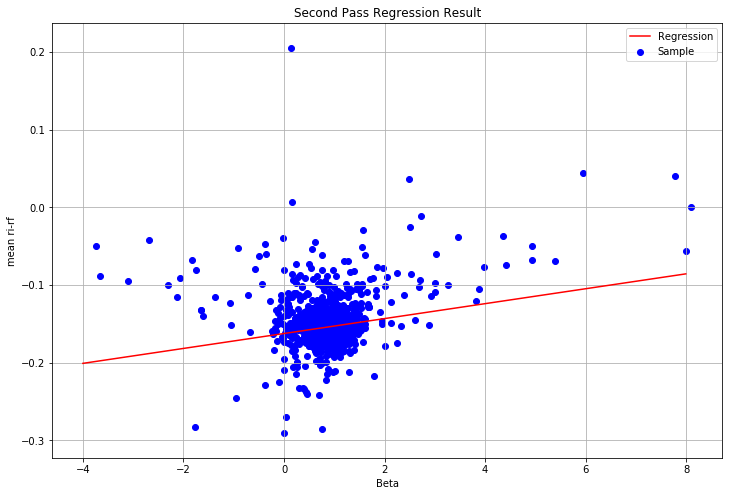

In [56]:
fig = plt.figure(figsize=(12,8))

plt.scatter(X,y, color='b', label='Sample')
plt.plot(np.arange(-4,8,0.01), LR.predict(np.arange(-4,8,0.01).reshape((-1,1))), color='r', label='Regression')
plt.grid(True)
plt.title("Second Pass Regression Result")
plt.xlabel("Beta")
plt.ylabel("mean ri-rf")
plt.legend(loc=1)

In [57]:
Regression_df.to_csv("Regression.csv")

## T-test

In [58]:
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     71.65
Date:                Fri, 08 Nov 2019   Prob (F-statistic):           6.21e-17
Time:                        20:04:43   Log-Likelihood:                 3059.2
No. Observations:                1452   AIC:                            -6114.
Df Residuals:                    1450   BIC:                            -6104.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1623      0.001   -130.083      0.000      -0.165      -0.160
x1             0.0096      0.001      8.464      0.000       0.007       0.012
==============================================================================
Omnibus:                      977.411   Durbin-Watson:                   1.638
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29724.397
Skew:                           2.682   Prob(JB):                         0.00
Kurtosis:                      24.507   Cond. No.                         2.90
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Result

P>|t| = 0.000 as the summary table has shown; therefore, the intersection is not significantly different from 0.


Conclusion: CAPM does not hold